<a href="https://colab.research.google.com/github/K-Jadeja/HuggingFace-LLMs/blob/main/Fine_tuning_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip  install transformers==4.22.1 -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 22.1 MB/s eta 0:00:00


In [3]:
import transformers

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [4]:
print(transformers.__version__)


4.22.1


In [5]:
!pip install -U tensorflow==2.12

In [6]:
import tensorflow as tf
print(tf.keras.__version__)

2.12.0


In [8]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
import os

In [10]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [11]:
pdf_folder_path = f"{root_dir}training/"
os.listdir(pdf_folder_path)

['train.csv', '.ipynb_checkpoints']

In [12]:
root_path = f"{root_dir}training/train.csv"
df = pd.read_csv(root_path)
df.head()

,category,text
0,SearchDynamicNews,Which city hosted a major international confer...
1,SearchDynamicNews,What is the current status of the cryptocurren...
2,SearchDynamicNews,What is the current status of the global clima...
3,NormalChat,I'm currently reading a mystery novel.
4,NormalChat,Have you seen the latest episode of that TV show?


In [13]:
df.shape


(116, 2)

In [14]:
df['count'] = df['text'].apply(lambda x: len(x.split()))
df.head()

,category,text,count
0,SearchDynamicNews,Which city hosted a major international confer...,7
1,SearchDynamicNews,What is the current status of the cryptocurren...,9
2,SearchDynamicNews,What is the current status of the global clima...,11
3,NormalChat,I'm currently reading a mystery novel.,6
4,NormalChat,Have you seen the latest episode of that TV show?,10


<Figure size 800x800 with 0 Axes>

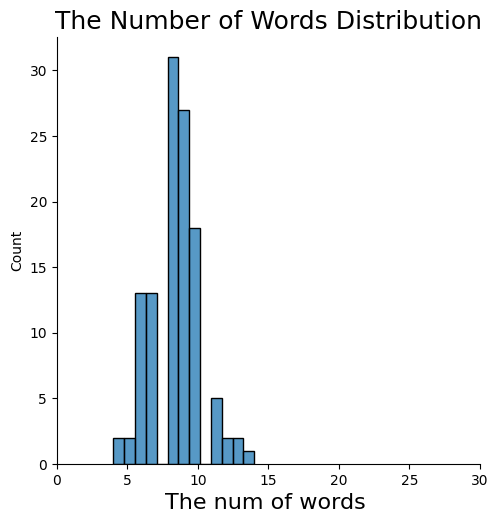

In [15]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 30)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [16]:
category_count = df['category'].value_counts()

categories = category_count.index

categories

Index(['SearchDynamicNews', 'NormalChat'], dtype='object')

In [17]:
category_count

SearchDynamicNews    69
NormalChat           47
Name: category, dtype: int64

In [18]:
category_count.index

Index(['SearchDynamicNews', 'NormalChat'], dtype='object')

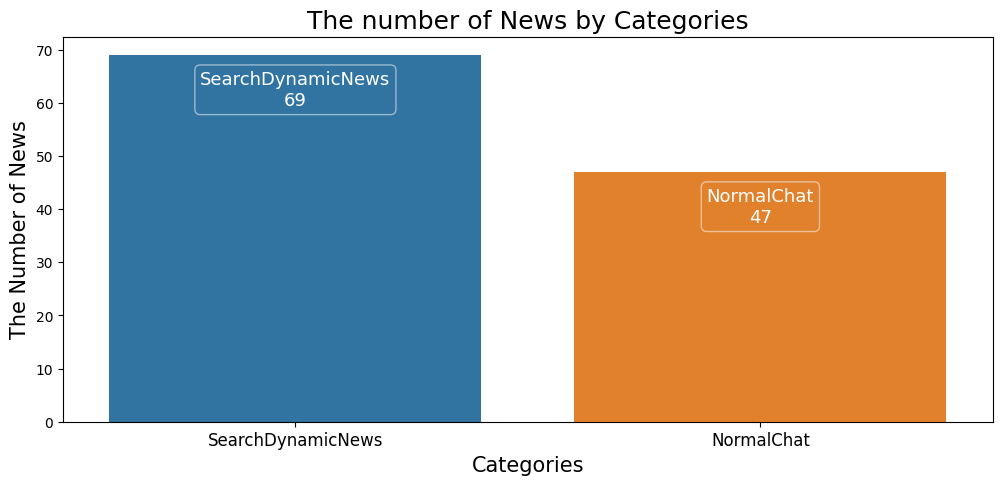

In [19]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [20]:
df['category'].unique()

array(['SearchDynamicNews', 'NormalChat'], dtype=object)

In [21]:
df['encoded_text'] = df['category'].astype('category').cat.codes

df.head(10)

,category,text,count,encoded_text
0,SearchDynamicNews,Which city hosted a major international confer...,7,1
1,SearchDynamicNews,What is the current status of the cryptocurren...,9,1
2,SearchDynamicNews,What is the current status of the global clima...,11,1
3,NormalChat,I'm currently reading a mystery novel.,6,0
4,NormalChat,Have you seen the latest episode of that TV show?,10,0
5,SearchDynamicNews,What are the updates on international trade ag...,8,1
6,SearchDynamicNews,Who is the CEO of Twitter?,6,1
7,SearchDynamicNews,What is the current situation of the pandemic ...,11,1
8,NormalChat,Board game nights are so much fun!,7,0
9,SearchDynamicNews,What is the breakthrough in cancer research?,7,1


In [22]:
data_texts = df['text'].to_list()

data_labels = df['encoded_text'].to_list()

In [23]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )


In [24]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [26]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [29]:
df.info

<bound method DataFrame.info of               category                                               text  \
0    SearchDynamicNews  Which city hosted a major international confer...   
1    SearchDynamicNews  What is the current status of the cryptocurren...   
2    SearchDynamicNews  What is the current status of the global clima...   
3           NormalChat             I'm currently reading a mystery novel.   
4           NormalChat  Have you seen the latest episode of that TV show?   
..                 ...                                                ...   
111  SearchDynamicNews            What is the update on the stock market?   
112  SearchDynamicNews        What are the updates on the global economy?   
113  SearchDynamicNews  Who is the current leader in the race for the ...   
114  SearchDynamicNews      What are the changes in immigration policies?   
115  SearchDynamicNews  Who is the current captain of the national soc...   

     count  encoded_text  
0        7      

In [27]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments


training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=1e-5,
    logging_dir='./logs',
    eval_steps=100
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 5 )


trainer = TFTrainer(
    model=trainer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [28]:
trainer.train()


UnimplementedError: ignored

In [30]:
trainer.evaluate()


{'eval_loss': 1.5469110012054443}

In [31]:
save_directory = /saved_models

tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

SyntaxError: ignored

In [ ]:
test_text = test_texts[0]

test_text

In [ ]:
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

prediction_value